# Nuclie Semantic Segmentation - UNet using Tensorflow 2

# Intro
- Dataset used is from Kaggle's Data Science Bowl 2018 - Nuclei Segmentation
- The architecture used is [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this.
- This notebook is inspired from the great kernel [Keras U-net starter - LB 0.277](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277) by Kjetil Åmdal-Sævik.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

#try:
#  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#except ValueError:
#  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.9.0


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, add, multiply
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import concatenate, Activation
from keras import backend as K

import tensorflow as tf

### Prediction Function

In [4]:
def prediction(model_path, X_test, img_size = (256, 256), thres = 0.5, verbose = 1):
    # Predict on train, val and test
    model = load_model(model_path)
    preds_test = model.predict(X_test, verbose=verbose)

    # Threshold predictions
    preds_test_t = (preds_test > thres).astype(np.uint8)

    # Create list of upsampled test masks
    preds_test_upsampled = []
    for i in range(len(preds_test_t)):
        preserve = np.squeeze(preds_test_t[i])
        res = resize(preserve, img_size, mode='constant', preserve_range=True)
        preds_test_upsampled.append(res.astype(np.uint8))
    return preds_test_upsampled

### Watershed for split nucleus

In [5]:
import cv2
import scipy.ndimage as ndi
from skimage.segmentation import watershed, find_boundaries
from skimage.feature import corner_peaks
from skimage.morphology import binary_dilation, disk
from skimage.color import label2rgb
from skimage.measure import regionprops_table

def make_boundary_image(L, A, thickness=1, color=(255,255,85), rescale_hist=True):
    if A.ndim == 2:
        A = np.stack((A,A,A), axis=2)
    if rescale_hist:
        A = np.interp(A, (np.amin(A), np.amax(A)), (0,255)).astype(np.uint8)
    else:
        A = A.astype(np.uint8)

    mask = find_boundaries(L)
    mask = binary_dilation(mask, footprint=disk(thickness))

    R = A[:,:,0].copy()
    G = A[:,:,1].copy()
    B = A[:,:,2].copy()

    R[mask] = color[0]
    G[mask] = color[1]
    B[mask] = color[2]

    return np.stack((R,G,B), axis=2)

def labelvis(A, L, bg_color='b'):
    bg_color_code = {
        'b': (0.1,0.1,0.5),
        'g': (0.1,0.5,0.1),
    }  
    A = label2rgb(L, A, bg_label=0, bg_color=bg_color_code[bg_color], alpha=0.3, image_alpha=1)
    A = np.interp(A, (0,1), (0,255)).astype(np.uint8)
    A = make_boundary_image(L, A)
    return A

# Create predict boundary image with label
# Input: image, label
# Output: rgb_watershed, boundary, mask, dataframe
def create_boundary(img, label):
    #Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
    ret1, thresh = cv2.threshold(label, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(label, peak_markers, mask=label)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)
    boundary = labelvis(img, markers)
    
    # regionprops function in skimage measure module calculates useful parameters for each object.
    params = ['label', 'area', 'bbox', 'equivalent_diameter', 'mean_intensity', 'solidity']
    props = regionprops_table(markers, intensity_image=X_test[0], properties=params)
    df = pd.DataFrame(props)
    
    return img_rgb, boundary, markers, df

In [6]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'dataset/stage1_train/'
TEST_PATH = 'dataset/stage1_test/'

dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

os.getcwd()

'/Users/cusniwtt/Documents/GitHub/unet-nucleus'

In [7]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data
- Downsample both the training and test images to reduce computations
- Retain record of the original sizes of the test images to upsample predicted masks and create correct run-length encodings 

In [8]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    #Read image files iteratively
    path = TRAIN_PATH + id_
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for train dataset
    X_train[n] = img
    
    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:

        # Remove .DS_Store file
        if mask_file == '.DS_Store':
            continue
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

        #Overlay individual masks to create a final mask for corresponding image
        try:
            mask = np.maximum(mask, mask_)
        except:
            print(mask_file)
    
    #Append mask to numpy array for train dataset
    Y_train[n] = mask


# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    
    #Read images iteratively
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    
    #Get test size
    sizes_test.append([img.shape[0], img.shape[1]])
    
    #Resize image to match training data
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for test dataset
    X_test[n] = img

    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:

        # Remove .DS_Store file
        if mask_file == '.DS_Store':
            continue
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

        #Overlay individual masks to create a final mask for corresponding image
        try:
            mask = np.maximum(mask, mask_)
        except:
            print(mask_file)
    
    #Append mask to numpy array for train dataset
    Y_test[n] = mask

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 100/100 [00:07<00:00, 14.03it/s]

Getting and resizing test images ... 



100%|██████████| 12/12 [00:00<00:00, 12.12it/s]

Done!


## Visualize imported data

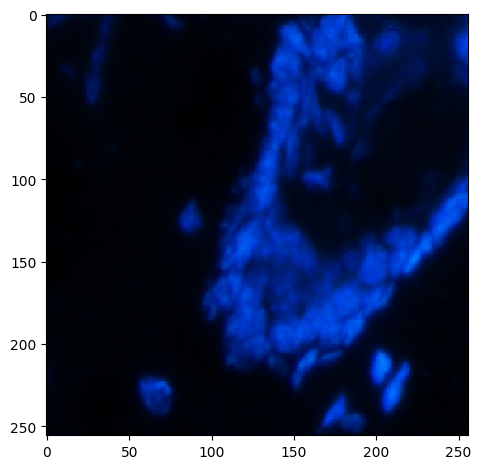

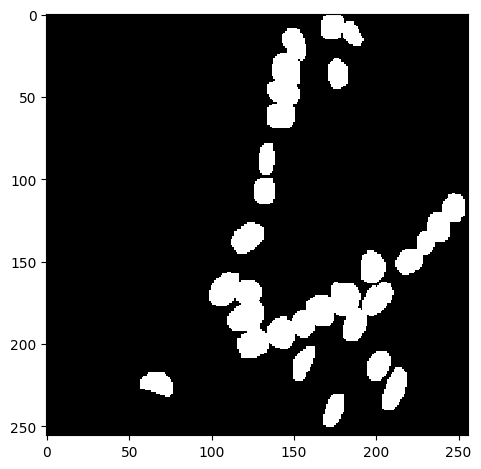

In [9]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [10]:
# Validation split
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(80, 256, 256, 3)
(20, 256, 256, 3)
(80, 256, 256, 1)
(20, 256, 256, 1)


## Data Augmentation

In [11]:
import albumentations as A
import cv2

transform = A.Compose([
    A.Resize(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.CLAHE(p=0.5),
])
rounds = 10
X_train_aug = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train_aug = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Augmentation train images and masks ... ')
for r in range(rounds):
    for n, id_ in tqdm(enumerate(X_train), total=X_train.shape[0]):
        X_img = X_train[n]
        Y_img = Y_train[n]*1
        augmented = transform(image=X_img, mask=Y_img.astype(np.uint8))
        if not np.any(augmented['mask']):
            continue
        else:
            X_train_aug = np.append(X_train_aug, augmented['image'].reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), axis=0)
            Y_train_aug = np.append(Y_train_aug, augmented['mask'].astype(bool).reshape(1, IMG_HEIGHT, IMG_WIDTH, 1), axis=0)

Augmentation train images and masks ... 


100%|██████████| 80/80 [00:02<00:00, 32.91it/s]


In [12]:
print(X_train_aug.shape)
print(Y_train_aug.shape)

(789, 256, 256, 3)
(789, 256, 256, 1)


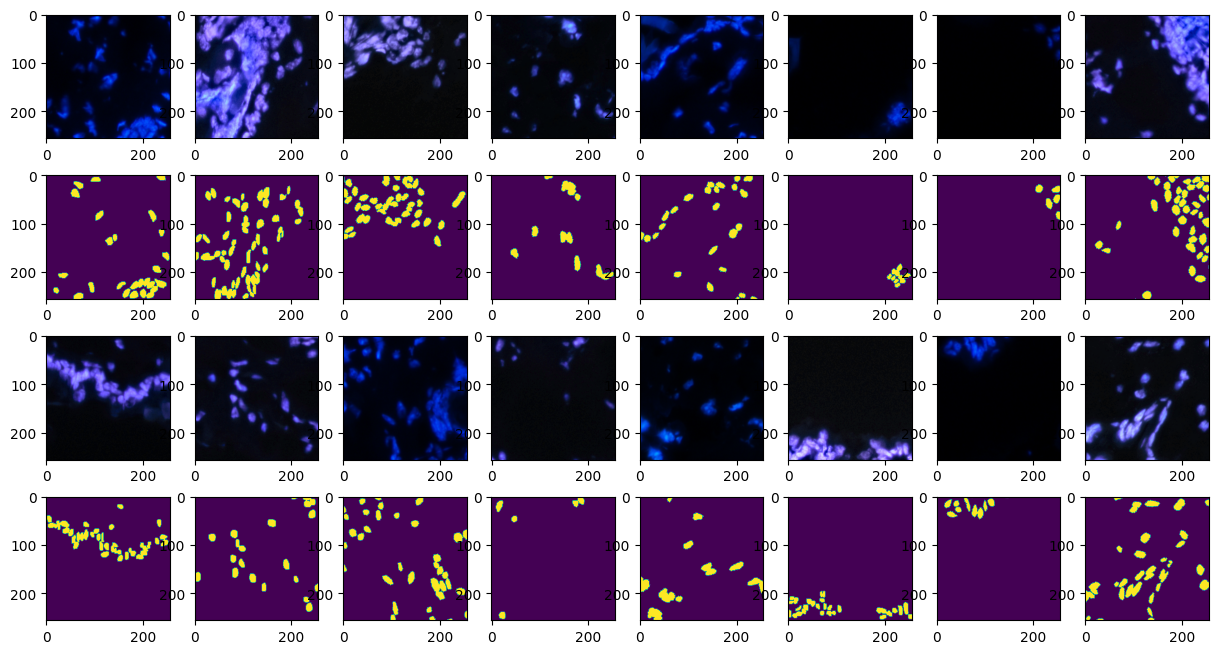

In [13]:
# Check if training data looks all right
X_train = X_train_aug
Y_train = Y_train_aug

ix = random.sample(range(0, X_train.shape[0]), 16)
fig, axs = plt.subplots(4, 8, figsize=(15, 8))
row = 0
col = 0
for i in ix:
  axs[row][col].imshow(X_train[i])
  axs[row+1][col].imshow(np.squeeze(Y_train[i]))
  col = col + 1
  if col == 8:
    col = 0
    row = row + 2

plt.show()

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="UNet" style="height: 400px; width:600px;"/>

## U-Net
from Kaggle

In [ ]:
# Build U-Net model

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    p = MaxPooling2D((2, 2), (2, 2))(c)
    p = Dropout(dropout)(p)
    return c, p

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.3):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = BatchNormalization()(c)
    c = Dropout(dropout)(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    return c

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2):
    us = UpSampling2D((2, 2))(x)
    concat = concatenate([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    c = Dropout(dropout)(c)
    return c

def unet_model(filters=64, input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), nn_name="unet"):
    inputs = Input(input)
    s = Lambda(lambda x: x / 255)(inputs)
    down1 = down_block(s, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    down2 = down_block(down1[1], filters*2, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    down3 = down_block(down2[1], filters*4, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    down4 = down_block(down3[1], filters*8, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    bottleneck1 = bottleneck(down4[1], filters*16, kernel_size=(3, 3), padding="same", strides=1, dropout=0.3)
    up1 = up_block(bottleneck1, down4[0], filters*8, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    up2 = up_block(up1, down3[0], filters*4, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    up3 = up_block(up2, down2[0], filters*2, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    up4 = up_block(up3, down1[0], filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(up4)
    model = Model(inputs=[inputs], outputs=[outputs], name=nn_name)
    return model

In [ ]:
model_repr = unet_model(filters=64, input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model_repr.summary()
del(model_repr)

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['lambda[0][0]']                 
                                )                                                                 
                                                                                               

### Optimizer Loss Metrics

In [ ]:
# Optimizer
from keras import optimizers
sgd = optimizers.SGD(learning_rate=0.002, decay=0.00003, momentum=0.9)
adam = optimizers.Adam(learning_rate=0.002, decay=0.00003)

# Loss function
from keras.losses import BinaryCrossentropy
bce = BinaryCrossentropy()

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

# Metrics
from keras.metrics import Recall, Precision
recall = Recall()
precision = Precision()

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# Fit model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
earlystopper = EarlyStopping(patience=15, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

### Adam, BCE

In [ ]:
# Adam, BCE, batch_size=8
logs_p = 'logs/unet_64_adam_bce_8.csv'
weights_p = 'weights/unet_64_adam_bce_8.h5'

checkpointer = ModelCheckpoint(weights_p, verbose=1, save_best_only=True)
callbacks_f = [earlystopper, checkpointer, reduce_lr, CSVLogger(logs_p, append=True, separator=';')]
metrics_f = [recall, precision,]
#batch_s = 8 * tpu_strategy.num_replicas_in_sync # with TPU
batch_s = 8
epochs_s = 100

#with tpu_strategy.scope():  # with TPU
#  model = unet_model(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
#  adam = optimizers.Adam(learning_rate=0.002, decay=0.00003)
#  bce = BinaryCrossentropy()
#  model.compile(optimizer=adam, loss=bce, metrics=[Recall(), Precision()])
model = unet_model(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
model.compile(optimizer=adam, loss=bce, metrics=metrics_f)

results = model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), batch_size=batch_s, 
                    epochs=epochs_s, callbacks=callbacks_f, verbose=1,)
K.clear_session()

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.3382 - recall: 0.7519 - precision: 0.4984
Epoch 1: val_loss improved from inf to 0.37536, saving model to weights/unet_64_adam_bce_8.h5
100/100 [==============================] - 92s 726ms/step - loss: 0.3382 - recall: 0.7519 - precision: 0.4984 - val_loss: 0.3754 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0020
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.1288 - recall: 0.6820 - precision: 0.7074
Epoch 2: val_loss improved from 0.37536 to 0.28309, saving model to weights/unet_64_adam_bce_8.h5
100/100 [==============================] - 66s 661ms/step - loss: 0.1288 - recall: 0.6820 - precision: 0.7074 - val_loss: 0.2831 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0020
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1060 - recall: 0.6537 - precision: 0.7259
Epoch 3: val_loss improved from 0.28309 to 0.22445, saving model to weigh

### SGD, BCE

In [ ]:
# SGD, BCE, batch_size=8
logs_p = 'logs/unet_64_sgd_bce_8.csv'
weights_p = 'weights/unet_64_sgd_bce_8.h5'

checkpointer = ModelCheckpoint(weights_p, verbose=1, save_best_only=True)
callbacks_f = [earlystopper, checkpointer, reduce_lr, CSVLogger(logs_p, append=True, separator=';')]
optimizer_f = sgd
loss_f = bce
metrics_f = [recall, precision,]
#batch_s = 8 * tpu_strategy.num_replicas_in_sync # with TPU
batch_s = 8
epochs_s = 100

#with tpu_strategy.scope():  # with TPU
#  model = unet_model(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
#  sgd = optimizers.SGD(learning_rate=0.002, decay=0.00003, momentum=0.9)
#  bce = BinaryCrossentropy()
#  model.compile(optimizer=sgd, loss=bce, metrics=[Recall(), Precision(),])
model = unet_model(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
model.compile(optimizer=sgd, loss=bce, metrics=[recall, precision,])

results = model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), batch_size=batch_s, 
                    epochs=epochs_s, callbacks=callbacks_f, verbose=1,)
K.clear_session()

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.4377 - recall: 0.8303 - precision: 0.3453
Epoch 1: val_loss improved from inf to 0.26633, saving model to weights/unet_64_sgd_bce_8.h5
100/100 [==============================] - 70s 672ms/step - loss: 0.4377 - recall: 0.8303 - precision: 0.3453 - val_loss: 0.2663 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0020
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.2078 - recall: 0.7159 - precision: 0.6564
Epoch 2: val_loss improved from 0.26633 to 0.23037, saving model to weights/unet_64_sgd_bce_8.h5
100/100 [==============================] - 66s 661ms/step - loss: 0.2078 - recall: 0.7159 - precision: 0.6564 - val_loss: 0.2304 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0020
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1561 - recall: 0.6774 - precision: 0.6936
Epoch 3: val_loss improved from 0.23037 to 0.19464, saving model to weights

### Adam, DICE + Jaccard

In [ ]:
# Adam, Dice+Jacard, batch_size=8
logs_p = 'logs/unet_64_adam_dice+jacard_8.csv'
weights_p = 'weights/unet_64_adam_dice+jacard_8.h5'

checkpointer = ModelCheckpoint(weights_p, verbose=1, save_best_only=True)
callbacks_f = [earlystopper, checkpointer, reduce_lr, CSVLogger(logs_p, append=True, separator=';')]
optimizer_f = adam
loss_f = [dice_coef_loss, jacard_coef_loss]
metrics_f = [dice_coef, jacard_coef,]
#batch_s = 8 * tpu_strategy.num_replicas_in_sync # with TPU
batch_s = 8
epochs_s = 100

#with tpu_strategy.scope():  # with TPU
#  model = unet_model(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
model = unet_model(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
model.compile(optimizer=optimizer_f, loss=loss_f, metrics=metrics_f)

results = model.fit(x=X_train, y=Y_train.astype(np.float32), validation_data=(X_val, Y_val.astype(np.float32)), batch_size=batch_s, 
                    epochs=epochs_s, callbacks=callbacks_f, verbose=1,)
K.clear_session()

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: -0.4226 - dice_coef: 0.4214 - jacard_coef: 0.2719
Epoch 1: val_loss improved from inf to -0.12810, saving model to weights/unet_64_adam_dice+jacard_8.h5
100/100 [==============================] - 72s 691ms/step - loss: -0.4226 - dice_coef: 0.4214 - jacard_coef: 0.2719 - val_loss: -0.1281 - val_dice_coef: 0.1252 - val_jacard_coef: 0.0668 - lr: 1.0000e-05
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: -0.5155 - dice_coef: 0.5130 - jacard_coef: 0.3478
Epoch 2: val_loss did not improve from -0.12810
100/100 [==============================] - 65s 652ms/step - loss: -0.5155 - dice_coef: 0.5130 - jacard_coef: 0.3478 - val_loss: -0.1121 - val_dice_coef: 0.1104 - val_jacard_coef: 0.0584 - lr: 1.0000e-05
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: -0.5393 - dice_coef: 0.5358 - jacard_coef: 0.3693
Epoch 3: val_loss did not improve from -0.12810
100/100 [=======================

### SGD, DICE + Jaccard

In [ ]:
# SGD, Dice+Jacard, batch_size=8
logs_p = 'logs/unet_64_sgd_dice+jacard_8.csv'
weights_p = 'weights/unet_64_sgd_dice+jacard_8.h5'

checkpointer = ModelCheckpoint(weights_p, verbose=1, save_best_only=True)
callbacks_f = [earlystopper, checkpointer, reduce_lr, CSVLogger(logs_p, append=True, separator=';')]
optimizer_f = sgd
loss_f = [dice_coef_loss, jacard_coef_loss]
metrics_f = [dice_coef, jacard_coef,]
#batch_s = 8 * tpu_strategy.num_replicas_in_sync # with TPU
batch_s = 8
epochs_s = 100

#with tpu_strategy.scope():  # with TPU
#  model = unet_model(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
model = unet_model(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), nn_name='SGD_DICE_JACCARD')
model.compile(optimizer=optimizer_f, loss=loss_f, metrics=metrics_f)

result = model.fit(x=X_train, y=Y_train.astype(np.float32), validation_data=(X_val, Y_val.astype(np.float32)), batch_size=batch_s, 
                    epochs=epochs_s, callbacks=callbacks_f, verbose=1,)
K.clear_session()

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: -0.3829 - dice_coef: 0.3849 - jacard_coef: 0.2434
Epoch 1: val_loss improved from inf to -0.11259, saving model to weights/unet_64_sgd_dice+jacard_8.h5
100/100 [==============================] - 88s 756ms/step - loss: -0.3829 - dice_coef: 0.3849 - jacard_coef: 0.2434 - val_loss: -0.1126 - val_dice_coef: 0.1108 - val_jacard_coef: 0.0587 - lr: 0.0020
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: -0.5501 - dice_coef: 0.5513 - jacard_coef: 0.3828
Epoch 2: val_loss did not improve from -0.11259
100/100 [==============================] - 66s 655ms/step - loss: -0.5501 - dice_coef: 0.5513 - jacard_coef: 0.3828 - val_loss: -0.0894 - val_dice_coef: 0.0890 - val_jacard_coef: 0.0466 - lr: 0.0020
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: -0.6204 - dice_coef: 0.6210 - jacard_coef: 0.4519
Epoch 3: val_loss improved from -0.11259 to -0.44308, saving model to weights/unet_64_sgd

## U-Net with InceptionResNetV2

In [ ]:
# Create U-Net model
from keras.applications import InceptionResNetV2
from keras.layers import ZeroPadding2D

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)

    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="InceptionResNetV2_U-Net")
    return model

In [ ]:
model = build_inception_resnetv2_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.summary()

### Optimizers

In [ ]:
# Optimizer
from keras import optimizers
sgd = optimizers.SGD(learning_rate=0.002, decay=0.00003, momentum=0.9)
adam = optimizers.Adam(learning_rate=0.002, decay=0.00003)

# Loss function
from keras.losses import BinaryCrossentropy
bce = BinaryCrossentropy()

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

# Metrics
from keras.metrics import Recall, Precision
recall = Recall()
precision = Precision()

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# Fit model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
earlystopper = EarlyStopping(patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

### Adam, BCE

In [ ]:
# Adam, BCE, batch_size=8
logs_p = 'logs/irnv2_unet_64_adam_bce_8.csv'
weights_p = 'weights/irnv2_unet_64_adam_bce_8.h5'

checkpointer = ModelCheckpoint(weights_p, verbose=1, save_best_only=True)
callbacks_f = [earlystopper, checkpointer, reduce_lr, CSVLogger(logs_p, append=True, separator=';')]
optimizer_f = adam
loss_f = [bce]
metrics_f = [recall, precision,]
batch_s = 8 * tpu_strategy.num_replicas_in_sync # with TPU
#batch_s = 8
epochs_s = 100

with tpu_strategy.scope():  # with TPU
    model = build_inception_resnetv2_unet(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
#model = unet_model(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
model.compile(optimizer=optimizer_f, loss=loss_f, metrics=metrics_f)

results = model.fit(x=X_train, y=Y_train.astype(np.float32), validation_data=(X_val, Y_val.astype(np.float32)), batch_size=batch_s, 
                    epochs=epochs_s, callbacks=callbacks_f, verbose=1,)
K.clear_session()

### SGD, BCE

In [ ]:
# SGD, BCE, batch_size=8
logs_p = 'logs/irnv2_unet_64_sgd_bce_8.csv'
weights_p = 'weights/irnv2_unet_64_sgd_bce_8.h5'

checkpointer = ModelCheckpoint(weights_p, verbose=1, save_best_only=True)
callbacks_f = [earlystopper, checkpointer, reduce_lr, CSVLogger(logs_p, append=True, separator=';')]
optimizer_f = sgd
loss_f = [bce]
metrics_f = [recall, precision,]
batch_s = 8 * tpu_strategy.num_replicas_in_sync # with TPU
#batch_s = 8
epochs_s = 100

with tpu_strategy.scope():  # with TPU
    model = build_inception_resnetv2_unet(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
#model = unet_model(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
model.compile(optimizer=optimizer_f, loss=loss_f, metrics=metrics_f)

results = model.fit(x=X_train, y=Y_train.astype(np.float32), validation_data=(X_val, Y_val.astype(np.float32)), batch_size=batch_s, 
                    epochs=epochs_s, callbacks=callbacks_f, verbose=1,)
K.clear_session()

### Adam, DICE + Jaccard

In [ ]:
# Adam, Dice+Jacard, batch_size=8
logs_p = 'logs/irnv2_unet_64_adam_dice+jacard_8.csv'
weights_p = 'weights/irnv2_unet_64_adam_dice+jacard_8.h5'

checkpointer = ModelCheckpoint(weights_p, verbose=1, save_best_only=True)
callbacks_f = [earlystopper, checkpointer, reduce_lr, CSVLogger(logs_p, append=True, separator=';')]
optimizer_f = adam
loss_f = [dice_coef_loss, jacard_coef_loss]
metrics_f = [dice_coef, jacard_coef,]
batch_s = 8 * tpu_strategy.num_replicas_in_sync # with TPU
#batch_s = 8
epochs_s = 100

with tpu_strategy.scope():  # with TPU
    model = build_inception_resnetv2_unet(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
#model = unet_model(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
model.compile(optimizer=optimizer_f, loss=loss_f, metrics=metrics_f)

results = model.fit(x=X_train, y=Y_train.astype(np.float32), validation_data=(X_val, Y_val.astype(np.float32)), batch_size=batch_s, 
                    epochs=epochs_s, callbacks=callbacks_f, verbose=1,)
K.clear_session()

### SGD, DICE + Jaccard

In [ ]:
# Adam, Dice+Jacard, batch_size=8
logs_p = 'logs/irnv2_unet_64_adam_dice+jacard_8.csv'
weights_p = 'weights/irnv2_unet_64_adam_dice+jacard_8.h5'

checkpointer = ModelCheckpoint(weights_p, verbose=1, save_best_only=True)
callbacks_f = [earlystopper, checkpointer, reduce_lr, CSVLogger(logs_p, append=True, separator=';')]
optimizer_f = sgd
loss_f = [dice_coef_loss, jacard_coef_loss]
metrics_f = [dice_coef, jacard_coef,]
batch_s = 8 * tpu_strategy.num_replicas_in_sync # with TPU
#batch_s = 8
epochs_s = 100

with tpu_strategy.scope():  # with TPU
    model = build_inception_resnetv2_unet(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
#model = unet_model(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
model.compile(optimizer=optimizer_f, loss=loss_f, metrics=metrics_f)

results = model.fit(x=X_train, y=Y_train.astype(np.float32), validation_data=(X_val, Y_val.astype(np.float32)), batch_size=batch_s, 
                    epochs=epochs_s, callbacks=callbacks_f, verbose=1,)
K.clear_session()

## Residual Attention U-Net with

In [14]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=3)(conv)
    conv = Activation("relu")(conv)

    conv = Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=3)(conv)
    conv = Activation("relu")(conv)
    
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=3)(conv)
    conv = Activation('relu')(conv)
    
    conv = Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=3)(shortcut)

    res_path = add([shortcut, conv])
    res_path = Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = multiply([upsample_psi, x])

    result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = BatchNormalization()(result)
    return result_bn

def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = BatchNormalization(axis=axis)(conv_final)
    conv_final = Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [15]:
input_shape = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
model = Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.1, batch_norm=True)
model.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 aliza

### Optimizer

In [16]:
# Optimizer
from keras import optimizers
sgd = optimizers.SGD(learning_rate=0.002, decay=0.00003, momentum=0.9)
adam = optimizers.Adam(learning_rate=0.002, decay=0.00003)

# Loss function
from keras.losses import BinaryCrossentropy
bce = BinaryCrossentropy()

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

# Metrics
from keras.metrics import Recall, Precision
recall = Recall()
precision = Precision()

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# Fit model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
earlystopper = EarlyStopping(patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

### Adam, BCE

In [17]:
# Adam, BCE, batch_size=8
logs_p = 'logs/ra_unet_64_adam_bce_8.csv'
weights_p = 'weights/ra_unet_64_adam_bce_8.h5'

checkpointer = ModelCheckpoint(weights_p, verbose=1, save_best_only=True)
callbacks_f = [earlystopper, checkpointer, reduce_lr, CSVLogger(logs_p, append=True, separator=';')]
optimizer_f = adam
loss_f = [bce]
metrics_f = [recall, precision,]
#batch_s = 8 * tpu_strategy.num_replicas_in_sync # with TPU
batch_s = 8
epochs_s = 100

#with tpu_strategy.scope():  # with TPU
#    model = build_inception_resnetv2_unet(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
model = Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.1, batch_norm=True)
model.compile(optimizer=optimizer_f, loss=loss_f, metrics=metrics_f)

results = model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), batch_size=batch_s, 
                    epochs=epochs_s, callbacks=callbacks_f, verbose=1,)
K.clear_session()

Epoch 1/100
99/99 [==============================] - ETA: 0s - loss: 0.5481 - recall: 0.9351 - precision: 0.5188
Epoch 1: val_loss improved from inf to 0.59356, saving model to weights/ra_unet_64_adam_bce_8.h5
99/99 [==============================] - 244s 2s/step - loss: 0.5481 - recall: 0.9351 - precision: 0.5188 - val_loss: 0.5936 - val_recall: 0.9727 - val_precision: 0.4216 - lr: 0.0020
Epoch 2/100
99/99 [==============================] - ETA: 0s - loss: 0.4675 - recall: 0.9109 - precision: 0.5879
Epoch 2: val_loss did not improve from 0.59356
99/99 [==============================] - 259s 3s/step - loss: 0.4675 - recall: 0.9109 - precision: 0.5879 - val_loss: 0.5974 - val_recall: 0.9511 - val_precision: 0.4962 - lr: 0.0020
Epoch 3/100
 5/99 [>.............................] - ETA: 32:02:00 - loss: 0.4333 - recall: 0.9149 - precision: 0.5653

### SGD, BCE

In [ ]:
# Adam, BCE, batch_size=8
logs_p = 'logs/ra_unet_64_sgd_bce_8.csv'
weights_p = 'weights/ra_unet_64_sgd_bce_8.h5'

checkpointer = ModelCheckpoint(weights_p, verbose=1, save_best_only=True)
callbacks_f = [earlystopper, checkpointer, reduce_lr, CSVLogger(logs_p, append=True, separator=';')]
optimizer_f = sgd
loss_f = [bce]
metrics_f = [recall, precision,]
#batch_s = 8 * tpu_strategy.num_replicas_in_sync # with TPU
batch_s = 8
epochs_s = 100

#with tpu_strategy.scope():  # with TPU
#    model = build_inception_resnetv2_unet(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
model = Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.1, batch_norm=True)
model.compile(optimizer=optimizer_f, loss=loss_f, metrics=metrics_f)

results = model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), batch_size=batch_s, 
                    epochs=epochs_s, callbacks=callbacks_f, verbose=1,)
K.clear_session()

### Adam, DICE + Jaccard

In [ ]:
# Adam, Dice+Jacard, batch_size=8
logs_p = 'logs/ra_unet_64_adam_dice+jacard_8.csv'
weights_p = 'weights/ra_unet_64_adam_dice+jacard_8.h5'

checkpointer = ModelCheckpoint(weights_p, verbose=1, save_best_only=True)
callbacks_f = [earlystopper, checkpointer, reduce_lr, CSVLogger(logs_p, append=True, separator=';')]
optimizer_f = adam
loss_f = [dice_coef_loss, jacard_coef_loss]
metrics_f = [dice_coef, jacard_coef,]
#batch_s = 8 * tpu_strategy.num_replicas_in_sync # with TPU
batch_s = 8
epochs_s = 100

#with tpu_strategy.scope():  # with TPU
#    model = build_inception_resnetv2_unet(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
model = Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.1, batch_norm=True)
model.compile(optimizer=optimizer_f, loss=loss_f, metrics=metrics_f)

results = model.fit(x=X_train, y=Y_train.astype(np.float32), validation_data=(X_val, Y_val.astype(np.float32)), batch_size=batch_s, 
                    epochs=epochs_s, callbacks=callbacks_f, verbose=1,)
K.clear_session()

### SGD, DICE + Jaccard

In [ ]:
# Adam, Dice+Jacard, batch_size=8
logs_p = 'logs/ra_unet_64_sgd_dice+jacard_8.csv'
weights_p = 'weights/ra_unet_64_sgd_dice+jacard_8.h5'

checkpointer = ModelCheckpoint(weights_p, verbose=1, save_best_only=True)
callbacks_f = [earlystopper, checkpointer, reduce_lr, CSVLogger(logs_p, append=True, separator=';')]
optimizer_f = sgd
loss_f = [dice_coef_loss, jacard_coef_loss]
metrics_f = [dice_coef, jacard_coef,]
#batch_s = 8 * tpu_strategy.num_replicas_in_sync # with TPU
batch_s = 8
epochs_s = 100

#with tpu_strategy.scope():  # with TPU
#    model = build_inception_resnetv2_unet(input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),)
model = Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.1, batch_norm=True)
model.compile(optimizer=optimizer_f, loss=loss_f, metrics=metrics_f)

results = model.fit(x=X_train, y=Y_train.astype(np.float32), validation_data=(X_val, Y_val.astype(np.float32)), batch_size=batch_s, 
                    epochs=epochs_s, callbacks=callbacks_f, verbose=1,)
K.clear_session()